## Observations and Insights 

In [ ]:
# 3 Major Observations from the data

#Mice treated with Ceftamin have a more broad distribution of final tumor volumes than other groups tested. This drug may be more effective than the others used in the study
#Within the Capomulin group of mice there does not seem to be any correlation between the weight of the mouse and the volume of the tumor at the end of the study.
# A final point is that it is most interesting that most of these drugs don't have the intended effects. The mean of tumor volume of the placebo was less than all other groups used in the study. Not a good sign for any of the drugs!

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

#Determine duplicates for each timepoint
nums=study_results.groupby(["Timepoint"]).count()
dups= study_results.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)
dups_count_df=pd.DataFrame({"Duplicate": dups})
study_results_dups=study_results.merge(dups_count_df,how="outer",left_index=True, right_index=True)
#Remove duplicates
study_results_dups2=study_results_dups.loc[study_results_dups["Duplicate"]!=True]
study_results_dups2=study_results_dups2.drop(columns=["Duplicate"])


# Combine the data into a single dataset

Times=nums.index.tolist()

for x in range(len(Times)):
    if x==0:
        results_combined=study_results_dups2.loc[study_results_dups2["Timepoint"]==Times[x]].drop(columns=["Timepoint"])
        column_names=list(results_combined.columns)
        del column_names[0]
    elif x==len(Times)-1:
        results_combined=results_combined.merge(study_results_dups2.loc[study_results_dups2["Timepoint"]==Times[x]], on="Mouse ID", how="outer", suffixes=('_T0',f'_T{x}')).drop(columns=["Timepoint"])
    else:
        results_combined=results_combined.merge(study_results_dups2.loc[study_results_dups2["Timepoint"]==Times[x]], on="Mouse ID", how="outer", suffixes=('',f'_T{x}')).drop(columns=["Timepoint"])


#Combine results DF with mouse DF
data_df=mouse_metadata.merge(results_combined, on="Mouse ID", how="outer",left_index=True, right_index=True)

#Getting rid of mice in metadata that was/were misslabelled in the study results set
data_df=data_df.loc[data_df["Tumor Volume (mm3)_T0"].isnull()==False]

# Display the data table for preview
data_df.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3)_T0,Metastatic Sites_T0,Tumor Volume (mm3)_T1,Metastatic Sites_T1,Tumor Volume (mm3)_T2,...,Tumor Volume (mm3)_T5,Metastatic Sites_T5,Tumor Volume (mm3)_T6,Metastatic Sites_T6,Tumor Volume (mm3)_T7,Metastatic Sites_T7,Tumor Volume (mm3)_T8,Metastatic Sites_T8,Tumor Volume (mm3)_T9,Metastatic Sites_T9
0,k403,Ramicane,Male,21,16,45.0,0.0,45.651331,0.0,43.270852,...,43.262145,1.0,40.605335,1.0,37.967644,1.0,38.379726,2.0,38.982878,2.0
1,s185,Capomulin,Female,3,17,45.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,x401,Capomulin,Female,16,15,45.0,0.0,48.791665,0.0,53.435987,...,64.663626,0.0,69.160520,0.0,71.905117,0.0,NaN,NaN,NaN,NaN
3,m601,Capomulin,Male,22,17,45.0,0.0,47.462891,0.0,49.783419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,g791,Ramicane,Male,11,16,45.0,0.0,45.769249,1.0,46.658395,...,51.828357,1.0,56.098998,1.0,57.729535,1.0,62.175705,1.0,NaN,NaN


## Summary Statistics

In [2]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method is the most straighforward, creating multiple series and putting them all together at the end.

#Identify stats for analysis
Stats=["mean", "median", "variance", "standard deviation", "SEM"]

#Determine variable for analysis
val=column_names[0]

#Calculate stats
for x in range(len(Times)):
    lbl=f"{val}_T{x}"
    if x==0:
        data_group_mean=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].mean()})
        data_group_median=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].median()})
        data_group_var=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].var()})
        data_group_std=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].std()})
        data_group_sem=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].sem()})
    else:
        data_group_mean[lbl]=data_df.groupby(["Drug Regimen"])[lbl].mean()
        data_group_median[lbl]=data_df.groupby(["Drug Regimen"])[lbl].median()
        data_group_var[lbl]=data_df.groupby(["Drug Regimen"])[lbl].var()
        data_group_std[lbl]=data_df.groupby(["Drug Regimen"])[lbl].std()
        data_group_sem[lbl]=data_df.groupby(["Drug Regimen"])[lbl].sem()

#Add stats to same dataframe
data_group_mean.insert(0,"Stat",[Stats[0] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_median.insert(0,"Stat",[Stats[1] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_var.insert(0,"Stat",[Stats[2] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_std.insert(0,"Stat",[Stats[3] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_sem.insert(0,"Stat",[Stats[4] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])

data_group=data_group_mean.append(data_group_median).append(data_group_var).append(data_group_std).append(data_group_sem)

#Reorganize index
data_group.reset_index(drop=False, inplace=True)
data_group=data_group.set_index(["Drug Regimen", "Stat"]).sort_index()

data_group

0.0               0.392311   
             mean                                 45.0              46.678219   
             median                               45.0              46.754269   
             standard deviation                    0.0               1.961557   
             variance                              0.0               3.847707   
Ketapril     SEM                                   0.0               0.377676   
             mean                                 45.0              46.131894   
             median                               45.0              46.493024   
             standard deviation                    0.0               1.730727   
             variance                              0.0               2.995415   
Naftisol     SEM                                   0.0               0.356202   
             mean                                 45.0              46.570970   
             median                               45.0              46.744077   
             standard deviation                    0.0               1.745027   
             variance                              0.0               3.045121   
Placebo      SEM                                   0.0               0.429466   
             mean                                 45.0              46.161373   
             median                               45.0              46.140826   
             standard deviation                    0.0               2.103946   
             variance                              0.0               4.426591   
Propriva     SEM                                   0.0               0.324600   
             mean                                 45.0              46.306628   
             median                               45.0              45.910041   
             standard deviation                    0.0               1.590207   
             variance                              0.0               2.528757   
Ramicane     SEM                                   0.0               0.493977   
             mean                                 45.0              46.625715   
             median                               45.0              46.431216   
             standard deviation                    0.0               2.469886   
             variance                              0.0               6.100335   
Stelasyn     SEM                                   0.0               0.425755   
             mean                                 45.0              46.307957   
             median                               45.0              46.377277   
             standard deviation                    0.0               1.996966   
             variance                              0.0               3.987874   
Zoniferol    SEM                                   0.0               0.476275   
             mean                                 45.0              45.956632   
             median                               45.0              46.684697   
             standard deviation                    0.0               2.333260   
             variance                              0.0               5.444101   

                                 Tumor Volume (mm3)_T2  Tumor Volume (mm3)_T3  \
Drug Regimen Stat                                                               
Capomulin    SEM                              0.326829               0.498236   
             mean                            49.434785              51.459113   
             median                          49.647087              51.211935   
             standard deviation               1.497720               2.228179   
             variance                         2.243164               4.964779   
Ceftamin     SEM                              0.871662               1.073905   
             mean                            46.696205              48.031538   
             median                          47.400683              49.176147   


## Bar and Pie Charts

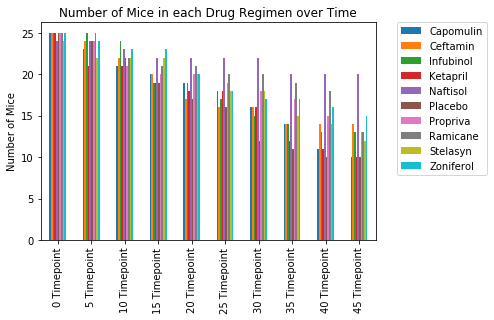

In [3]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 

Groups = data_df.groupby(["Drug Regimen"]).count().index.tolist()

#group data by each specific time and make new dataframe
graph_df=pd.DataFrame({"Time0":data_df.groupby(["Drug Regimen"])[f"{val}_T0"].count(),
                       "Time1":data_df.groupby(["Drug Regimen"])[f"{val}_T1"].count(),
                       "Time2":data_df.groupby(["Drug Regimen"])[f"{val}_T2"].count(),
                       "Time3":data_df.groupby(["Drug Regimen"])[f"{val}_T3"].count(),
                       "Time4":data_df.groupby(["Drug Regimen"])[f"{val}_T4"].count(),
                       "Time5":data_df.groupby(["Drug Regimen"])[f"{val}_T5"].count(),
                       "Time6":data_df.groupby(["Drug Regimen"])[f"{val}_T6"].count(),
                       "Time7":data_df.groupby(["Drug Regimen"])[f"{val}_T7"].count(),
                       "Time8":data_df.groupby(["Drug Regimen"])[f"{val}_T8"].count(),
                       "Time9":data_df.groupby(["Drug Regimen"])[f"{val}_T9"].count()})
graph_df=graph_df.transpose()

Times_axis = [str(x)+ " Timepoint" for x in Times]

#plot graph
multiplot = graph_df.plot.bar()
plt.title('Number of Mice in each Drug Regimen over Time')
plt.ylabel('Number of Mice')
multiplot.legend(loc='center left',bbox_to_anchor=(1.05, .65))
multiplot = multiplot.set_xticklabels(Times_axis, rotation='vertical')


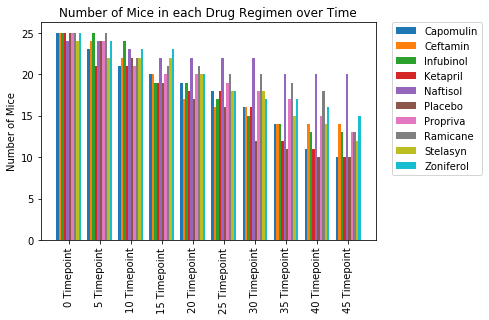

In [16]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

ind=np.arange(len(Groups))
width=.08

#group data by each specific time and make new dataframe
fig, ax = plt.subplots()
rects0 = ax.bar(ind - 9*width/2, graph_df[Groups[0]], width, label=Groups[0])
rects1 = ax.bar(ind - 7*width/2, graph_df[Groups[1]], width, label=Groups[1])
rects2 = ax.bar(ind - 5*width/2, graph_df[Groups[2]], width, label=Groups[2])
rects3 = ax.bar(ind - 3*width/2, graph_df[Groups[3]], width, label=Groups[3])
rects4 = ax.bar(ind - width/2, graph_df[Groups[4]], width, label=Groups[4])
rects5 = ax.bar(ind + width/2, graph_df[Groups[5]], width, label=Groups[5])
rects6 = ax.bar(ind + 3*width/2, graph_df[Groups[6]], width, label=Groups[6])
rects7 = ax.bar(ind + 5*width/2, graph_df[Groups[7]], width, label=Groups[7])
rects8 = ax.bar(ind + 7*width/2, graph_df[Groups[8]], width, label=Groups[8])
rects9 = ax.bar(ind + 9*width/2, graph_df[Groups[9]], width, label=Groups[9])


#plot graph
ax.set_ylabel('Number of Mice')
ax.set_title('Number of Mice in each Drug Regimen over Time')
ax.set_xticks(ind)
ax.set_xticklabels(Times_axis, rotation='vertical')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


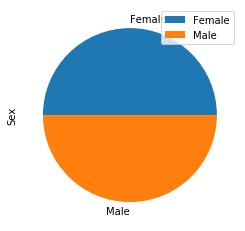

In [5]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

sex_df=pd.DataFrame({"Sex": data_df.groupby(["Sex"])[f"{val}_T0"].count()})
plot= sex_df.plot.pie(y="Sex")

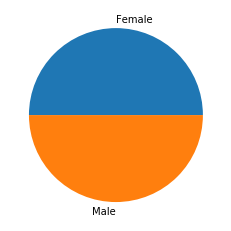

In [6]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

plot=plt.pie(sex_df["Sex"].tolist(),labels=sex_df["Sex"].index)

## Quartiles, Outliers and Boxplots

In [7]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
regimens=["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
Quart_values=["Upper Quartile (mm3)","Median (mm3)","Lower Quartile (mm3)","IQR (mm3)","Upper Bound (mm3)","Lower Bound (mm3)"]

#Define final volume dataframe
#Merge metadata with final volume
Final_Vol=mouse_metadata.merge(data_df[f"{val}_T{len(Times)-1}"], how="outer",left_index=True, right_index=True)

Final_Vol=Final_Vol.loc[Final_Vol[f"{val}_T{len(Times)-1}"].isnull()==False]

#Calculate quartiles for each regimine
#Calculate specific dataframe for each particular regmine
for x in range(len(regimens)):
    if x==0:
        Final_Vol_selected=Final_Vol.loc[Final_Vol["Drug Regimen"]==regimens[x]]
        vol_it=Final_Vol.loc[Final_Vol["Drug Regimen"]==regimens[x]]
        quartiles=vol_it[f"{val}_T{len(Times)-1}"].quantile([.25,.5,.75])
        quartiles=[float(quartiles[.25]), float(quartiles[.5]), float(quartiles[.75])] #numpy doesnt play with python....
        quart_data=[round(quartiles[2],2), round(quartiles[1],2), round(quartiles[0],2),
                    round(quartiles[2]-quartiles[0],2), round(2.5*quartiles[2]-1.5*quartiles[0],2),
                    round(2.5*quartiles[0]-1.5*quartiles[2],2)]
        quart_data_tot=pd.DataFrame({regimens[x]:quart_data},index=Quart_values)
        outliers=vol_it.loc[(vol_it[f"{val}_T{len(Times)-1}"]>quart_data[4]) | (vol_it[f"{val}_T{len(Times)-1}"]<quart_data[5])]
    else:
        Final_Vol_selected=Final_Vol_selected.append(Final_Vol.loc[(Final_Vol["Drug Regimen"]==regimens[x])])
        vol_it=Final_Vol.loc[Final_Vol["Drug Regimen"]==regimens[x]]
        quartiles=vol_it[f"{val}_T{len(Times)-1}"].quantile([.25,.5,.75])
        quartiles=[float(quartiles[.25]), float(quartiles[.5]), float(quartiles[.75])]
        quart_data=[round(quartiles[2],2), round(quartiles[1],2), round(quartiles[0],2),
                    round(quartiles[2]-quartiles[0],2), round(2.5*quartiles[2]-1.5*quartiles[0],2),
                    round(2.5*quartiles[0]-1.5*quartiles[2],2)]
        quart_data_tot[regimens[x]]=quart_data
        if outliers.empty:
            outliers=vol_it.loc[(vol_it[f"{val}_T{len(Times)-1}"]>quart_data[4]) | (vol_it[f"{val}_T{len(Times)-1}"]<quart_data[5])]
        else:
            outliers=outliers.append(vol_it.loc[(vol_it[f"{val}_T{len(Times)-1}"]>quart_data[4]) | (vol_it[f"{val}_T{len(Times)-1}"]<quart_data[5])])

#Show outliers
outliers

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3)_T9
0,k403,Ramicane,Male,21,16,38.982878
70,c139,Infubinol,Male,11,28,32.978522
74,c326,Infubinol,Female,18,25,40.667713
237,y163,Infubinol,Female,17,27,41.581521


In [8]:
#Show Quartile data for each group
quart_data_tot

,Capomulin,Ramicane,Infubinol,Ceftamin
Upper Quartile (mm3),71.64,73.87,69.30,66.28
Median (mm3),67.76,67.69,67.75,61.97
Lower Quartile (mm3),65.69,63.95,59.74,36.74
IQR (mm3),5.94,9.92,9.56,29.54
Upper Bound (mm3),80.55,88.75,83.64,110.58
Lower Bound (mm3),56.78,49.06,45.41,-7.56


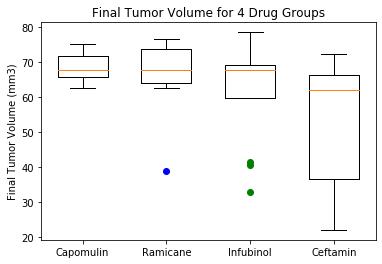

In [17]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#Separate data into each group
data_0=Final_Vol_selected[f"{val}_T{len(Times)-1}"].loc[Final_Vol_selected["Drug Regimen"]==regimens[0]].tolist()
data_1=Final_Vol_selected[f"{val}_T{len(Times)-1}"].loc[Final_Vol_selected["Drug Regimen"]==regimens[1]].tolist()
data_2=Final_Vol_selected[f"{val}_T{len(Times)-1}"].loc[Final_Vol_selected["Drug Regimen"]==regimens[2]].tolist()
data_3=Final_Vol_selected[f"{val}_T{len(Times)-1}"].loc[Final_Vol_selected["Drug Regimen"]==regimens[3]].tolist()

#Plot box plots
fig, ax = plt.subplots()
ax.boxplot(data_0, positions = [1], widths = 0.6 ,sym='r')
ax.boxplot(data_1, positions = [2], widths = 0.6 ,sym='b')
ax.boxplot(data_2, positions = [3], widths = 0.6 ,sym='g')
ax.boxplot(data_3, positions = [4], widths = 0.6 ,sym='m')
ax.set_ylabel('Final Tumor Volume (mm3)')
ax.set_title('Final Tumor Volume for 4 Drug Groups')
ax.set_xticklabels(regimens)
plt.show()

## Line and Scatter Plots

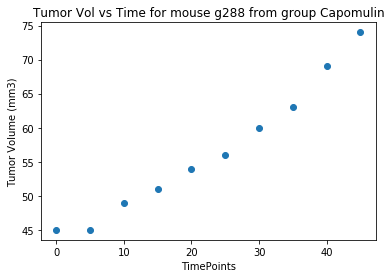

In [11]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
from random import randrange

#Find random mouse from Capomulin
ran=randrange(Final_Vol_selected[f"{val}_T{len(Times)-1}"].loc[Final_Vol_selected["Drug Regimen"]==regimens[0]].count())

#Find mouse index
mouse=Final_Vol_selected[f"{val}_T{len(Times)-1}"].loc[Final_Vol_selected["Drug Regimen"]==regimens[0]].reset_index().iloc[ran]
mouse_index= int(mouse['index'])

#make mouse dataframe for graph
mouse_data=data_df.loc[data_df.index==mouse_index]
mouse_data
m_data=[]
for x in range(len(Times)):
    m_data.append(int(mouse_data[f"{val}_T{x}"]))

#graph results
plt.scatter(Times,m_data)
plt.ylabel("Tumor Volume (mm3)")
plt.title(f'Tumor Vol vs Time for mouse {mouse_data["Mouse ID"].tolist()[0]} from group {regimens[0]}')
plt.xlabel("TimePoints")
plt.show()

## Correlation and Regression

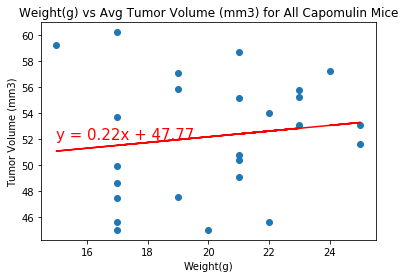

Correlation : 0.13


In [12]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen

#This part is super unclear, as there are multiple ways to talk about "Average tumor volume". What are you taking the average over? The mice that completed the study or all mice? So I did both. And did the correlation with just the final volume as well. 

#Average tumor volume for all Capomulin mice
#Find dataframe
data_Cap=data_df.loc[data_df["Drug Regimen"]==regimens[0]]
site=column_names[1]

#Remove columns to caclulate means
col=["Drug Regimen", "Sex", "Age_months"]
for x in range(len(Times)):
    col.append(f"{site}_T{x}")
data_Cap=data_Cap.drop(columns=col)

Tumor_vol=data_Cap.drop(columns=["Mouse ID","Weight (g)"])

Tumor_vol["Tumor Volume Mean"]=Tumor_vol.mean(axis=1)

#dataframe of data
avg_vol_data=pd.DataFrame({"Weight (g)": data_Cap["Weight (g)"],
                           "Tumor Volume Mean": Tumor_vol["Tumor Volume Mean"]})

#Calculate regression equation and correlation
(slope1, intercept1, rvalue1, pvalue1, stderr1) = linregress(avg_vol_data["Weight (g)"], avg_vol_data["Tumor Volume Mean"])
regress_values1 = avg_vol_data["Weight (g)"] * slope1 + intercept1
line_eq1 = "y = " + str(round(slope1,2)) + "x + " + str(round(intercept1,2))
correlation1 = st.pearsonr(avg_vol_data["Weight (g)"], avg_vol_data["Tumor Volume Mean"])

#Plot Graph
plt.scatter(avg_vol_data["Weight (g)"], avg_vol_data["Tumor Volume Mean"])
plt.plot(avg_vol_data["Weight (g)"],regress_values1,"r-")
plt.annotate(line_eq1,(15,52),fontsize=15,color="red")
plt.ylabel("Tumor Volume (mm3)")
plt.title('Weight(g) vs Avg Tumor Volume (mm3) for All Capomulin Mice')
plt.xlabel("Weight(g)")
plt.show()

#Print correlation
print(f'Correlation : {round(correlation1[0],2)}')

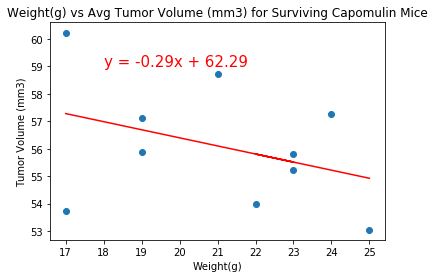

Correlation : -0.37


In [13]:
#Average tumor volume for surviving Capomulin mice

#find dataframe of data including only surviving mice
Tumor_adj=avg_vol_data.merge(data_Cap[f"{val}_T{x}"], how="outer",left_index=True, right_index=True)

Tumor_adj=Tumor_adj.loc[Tumor_adj[f"{val}_T{x}"].isnull()==False].drop(columns=[f"{val}_T{x}"])

#Calculate regression equation and correlation
(slope3, intercept3, rvalue3, pvalue3, stderr3) = linregress(Tumor_adj["Weight (g)"], Tumor_adj["Tumor Volume Mean"])
regress_values3 = Tumor_adj["Weight (g)"] * slope3 + intercept3
line_eq3 = "y = " + str(round(slope3,2)) + "x + " + str(round(intercept3,2))
correlation3 = st.pearsonr(Tumor_adj["Weight (g)"], Tumor_adj["Tumor Volume Mean"])

#Plot Graph
plt.scatter(Tumor_adj["Weight (g)"], Tumor_adj["Tumor Volume Mean"])
plt.plot(Tumor_adj["Weight (g)"],regress_values3,"r-")
plt.annotate(line_eq3,(18,59),fontsize=15,color="red")
plt.ylabel("Tumor Volume (mm3)")
plt.title('Weight(g) vs Avg Tumor Volume (mm3) for Surviving Capomulin Mice')
plt.xlabel("Weight(g)")
plt.show()

#Print correlation
print(f'Correlation : {round(correlation3[0],2)}')

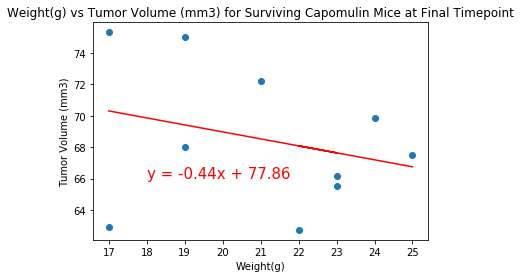

Correlation : -0.28


In [14]:
#Plot data for final avg tumor volume
data_Cap2=data_Cap.loc[data_Cap[f"{val}_T{x}"].isnull()==False]

#Calculate regression equation and correlation
(slope2, intercept2, rvalue2, pvalue2, stderr2) = linregress(data_Cap2["Weight (g)"], data_Cap2[f"{val}_T{x}"])
regress_values2 = data_Cap2["Weight (g)"] * slope2 + intercept2
line_eq2 = "y = " + str(round(slope2,2)) + "x + " + str(round(intercept2,2))
correlation2 = st.pearsonr(data_Cap2["Weight (g)"], data_Cap2[f"{val}_T{x}"])

#Plot Graph
plt.scatter(data_Cap2["Weight (g)"], data_Cap2[f"{val}_T{x}"])
plt.plot(data_Cap2["Weight (g)"],regress_values2,"r-")
plt.annotate(line_eq2,(18,66),fontsize=15,color="red")
plt.ylabel("Tumor Volume (mm3)")
plt.title('Weight(g) vs Tumor Volume (mm3) for Surviving Capomulin Mice at Final Timepoint')
plt.xlabel("Weight(g)")
plt.show()

#Print correlation
print(f'Correlation : {round(correlation2[0],2)}')